In [1]:
# Hyperparameters
test_results = True
N = 6
n_from_index = 0 # How far the first point is
# K nearest neighbors
K = 8

# N iterations to consider
i_j = 4
i_j_all = False

# Number of points to consider for convex margin constraints
CM = 5

frame_rate = 10

In [2]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from casadi import *

import utils
from utils import get_position, my_odometry


DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.7
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0, 'win32_disable_shaping': False}


In [3]:
plt.rcParams['figure.figsize'] = [7, 7]

In [4]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [5]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
    frame_rate=frame_rate,
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [6]:
start_from_trajectory = True

# Trick to let the trajectory extractor see the whole line
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]

In [7]:
dt = 1.0 / env.frame_rate

In [8]:
env.reset()
traj = utils.get_trajectory(env, samples=500, method="distance", last_value_distance=1.035)

/home/giulio/prog/duckrace/utils.py:390: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [9]:
if start_from_trajectory:
    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]
    # Why double? Good question
    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]

In [10]:
pose = get_position(env)
pose

Position(x=2.0549999999999997, y=1.9297064071170351, theta=1.5707963267948966)

Text(1.9486294618007634, 1.9308421914242628, '|---------|')

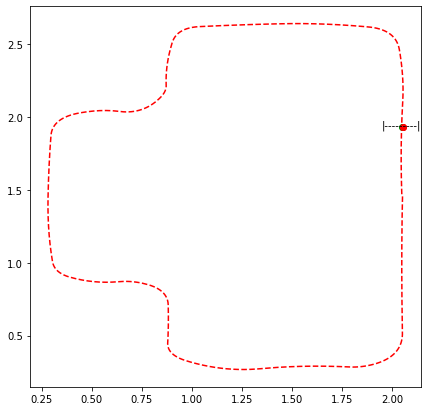

In [11]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index += n_from_index
startpoint = (traj[index,0], traj[index,1])
plt.plot(*traj.T, "r--")
plt.scatter(pose.x, pose.y, c="r")
plt.scatter(traj[index,0], traj[index,1], c="g")
plt.scatter(pose.x, pose.y, c="r")
plt.text(startpoint[0]-0.1, startpoint[1], '|'+'-'*9+'|')

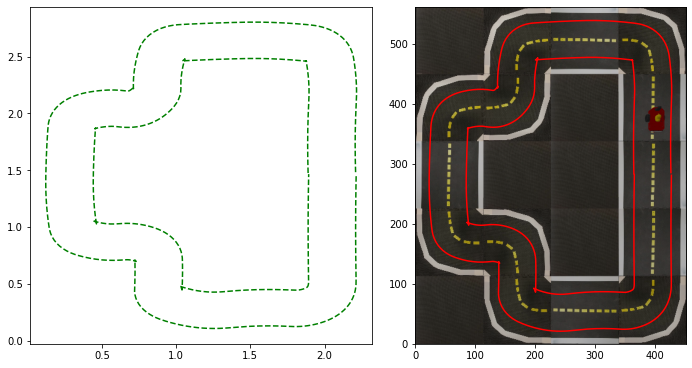

In [12]:
inside, outside = utils.get_border(traj, distance=0.16)
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AB""")
ax_dict["A"].plot(*inside.T, "g--")
ax_dict["A"].plot(*outside.T, "g--")
utils.show_on_map_array(env, inside, fig=ax_dict["B"])
utils.show_on_map_array(env, outside, fig=ax_dict["B"])

In [13]:
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
angles[:-1] = np.arctan2(traj[1:,1]-traj[:-1,1], traj[1:,0]-traj[:-1,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)
index = DM(index)
traj = DM(traj)
pose = get_position(env)

In [14]:
N_MPC = 10

delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
# N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N_MPC+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N_MPC+1)

# With preview
# Initial reference point
r0 = traj[index:index+N_MPC+1, :2].T
t0 = traj[index:index+N_MPC+1, 2].T

In [15]:
F = utils.model_F(dt=dt)

In [16]:
from collections import namedtuple
Line = namedtuple('Line', 't x y theta')
finish_line = Line(10*env.frame_rate, pose.x, pose.y, pose.theta) #2.2 same as start

In [17]:
opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
l = opti.variable(K*i_j)      # Lambda of convex hull
l_margin = opti.variable(CM, N)      # Lambda for convex combination of margin
x0 = opti.parameter(5,1)    # Parameter to set the initial state conditions (x(0))
D = opti.parameter(5,K*i_j)     # Nearest neighbors
J = opti.parameter(1, K*i_j)    # A matrix time, iteration with the old states
t_to_N = opti.parameter(1, N-1)  # Next t time steps
margins = opti.parameter(2, CM)   # Margins for the track bound constraints
old_optimal_distance_squared = opti.parameter(1) # Distance to the old next optimal point


obj = J@l

opti.minimize(obj)

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k_ in range(0,N):
   opti.subject_to(x[:,k_+1] == F(x[:,k_],u[:,k_])) # No delay
   opti.subject_to(x[:2,k_+1] == margins@l_margin[:,k_]) # Convex combination of margins
opti.subject_to(sum1(l_margin) == 1) # Sum of convex coefficients of margins = 1
opti.subject_to(vec(l_margin) >= 0) # Convex coefficients of margins >= 0

opti.subject_to((x[0,0] - x[0,1])**2 + (x[1,0] - x[1,1])**2 >= old_optimal_distance_squared)
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= 0)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == x0)
# 4) Set the convex hull constraints
opti.subject_to(l >= 0)
opti.subject_to(sum1(l) == 1)
opti.subject_to(D@l == x[:,N])

opti.set_value(x0,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0 # 8 to see constraint violations, see https://stackoverflow.com/questions/44558507/how-to-find-which-constraint-is-violated-from-pyomos-ipopt-interface
opts["ipopt.acceptable_constr_viol_tol"] = 1e-5
opts["print_time"] = False
opts["verbose"] = False
opti.solver('ipopt',opts)

In [18]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[x0, D, J, t_to_N, margins, old_optimal_distance_squared],[u[:,0], l],['x0', 'D', 'J', 't_to_N', 'central_line', 'distance'],['u_opt', "lambda"])

## Loop 0

In [19]:
# First loop
Mpc = Function.load('M.casadi')


# MPC loop
F = utils.model_F(dt=dt)
X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
r = r0
tr = t0
idx = index
u_delay = u_delay0

kdtree = spatial.KDTree(traj[:, :2])

t = 0
while True:
    u = Mpc(x, r, tr, u_delay,  1e3, 5e-4, 1, 1e-3)

    U_log = np.column_stack((U_log, u))
    X_log = np.column_stack((X_log, x))

    u_delay = np.column_stack((u_delay, u))[:, -delay:]

    # simulate
    x = F(x,u)

    distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2

    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    if idx+N_MPC+1 < traj.shape[0]:
        r = traj[idx:idx+N_MPC+1, :2].T
        tr = traj[idx:idx+N_MPC+1, 2].T
    else:
        r = vertcat(traj[idx:, :2], traj[:idx+N_MPC+1-traj.shape[0], :2]).T
        tr = vertcat(traj[idx:, 2], traj[:idx+N_MPC+1-traj.shape[0], 2]).T

    if traj[idx, 1] >= finish_line.y and t >= finish_line.t:
        break
    t += 1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



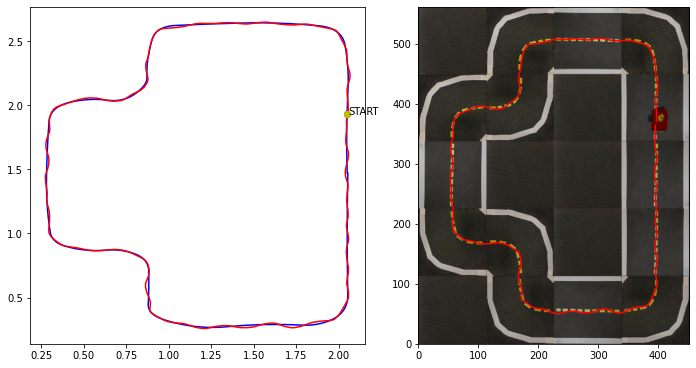

In [20]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

In [21]:
# all_points: [x, y, theta, v, w, steps to arrive]
all_points = X_log
X_log_orig = X_log
first_loop_len = all_points.shape[1]
all_points = np.vstack((all_points, np.arange(first_loop_len)[::-1]))
all_points_orig = all_points
x_orig = x

### Test sectors definition

In [22]:
def get_angles(x, y, x0=None, y0=None):
    """
    Get the angles of the trajectory.
    
    :param x: x coordinates
    :param y: y coordinates
    :param x0: x coordinate of the origin
    :param y0: y coordinate of the origin
    """

    if x0 is None:
        x0 = np.mean(x)
    if y0 is None:
        y0 = np.mean(y)

    r = np.sqrt((x-x0)**2 + (y-y0)**2)

    angles = np.where((y-y0) > 0, np.arccos((x-x0)/r), 2*np.pi-np.arccos((x-x0)/r))

    return angles

0.7265425280053609


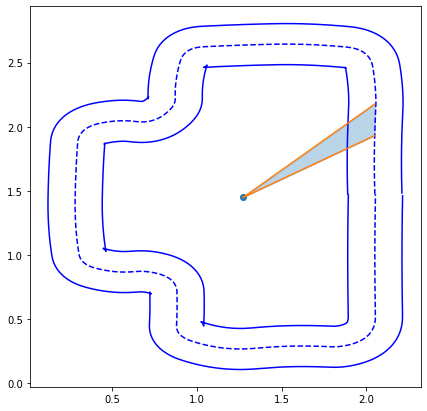

In [23]:
n_sectors = 10
assert n_sectors > 4
sector_size = 2*np.pi/n_sectors

plt.plot(*inside.T, c="b")
plt.plot(*outside.T, c="b")
plt.plot(traj[:,0], traj[:,1], "b--")
mean = traj[:,:2].toarray().mean(axis=0)
plt.scatter(*mean)

y0 = np.sqrt(1/np.cos(sector_size)**2-1)
x = np.array([mean[0], startpoint[0]])
y1 = np.array([mean[1], startpoint[1]])
y2 = np.array([mean[1], mean[1]+y0])
print(y0)

plt.plot(x, y1, c='C1')
plt.plot(x, y2, c='C1')
plt.fill_between(x, y1, y2, color='C0', alpha=0.3, interpolate=True)

IDEA: if angle % sector_size == 0 -> new sector

## Loop > 0

In [24]:
from sklearn.neighbors import NearestNeighbors

In [25]:
from IPython import display as ipythondisplay
from timeit import default_timer as timer

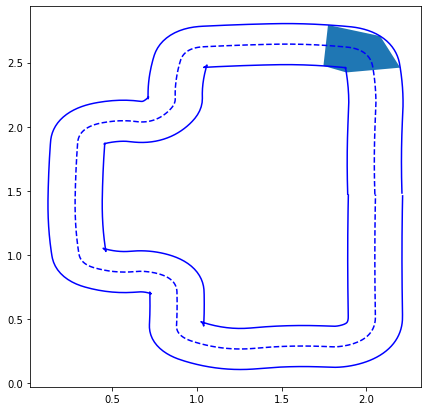

In [26]:
plt.plot(*inside.T, c="b")
plt.plot(*outside.T, c="b")
plt.plot(traj[:,0], traj[:,1], "b--")
idx = 63
more = 20
plt.fill([inside[idx,0], outside[idx,0], outside[idx+N+5,0], outside[idx+N+more,0], inside[idx+N+more,0]], [inside[idx,1], outside[idx,1], outside[idx+N+5,1], outside[idx+N+more,1], inside[idx+N+more,1]])

IDEA 2: just check that the first N=1 is better then the best overall
Distance from point to best point + distance from best point to next best point

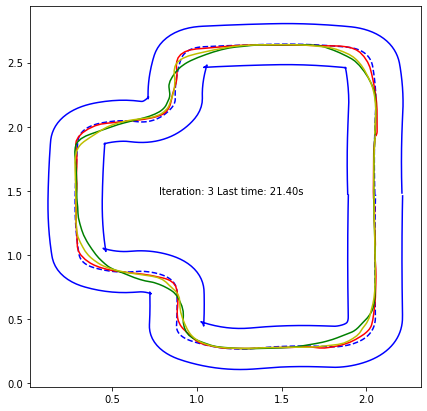

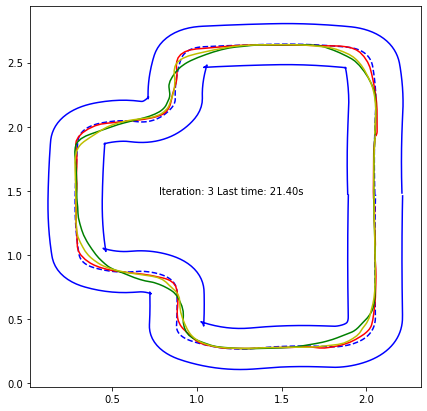

In [29]:
n_iterations = 3

real_time_plot = True

# For debugging
X_log = X_log_orig
# X_log[2,:] = (X_log_orig[2,:]+np.pi) % (2*np.pi) - np.pi
all_points = all_points_orig
# all_points[2,:] = (all_points_orig[2,:]+np.pi) % (2*np.pi) - np.pi
last_iterations = np.hstack([all_points]*i_j)
x = x_orig

F = utils.model_F(dt=dt)

if idx+N > all_points.shape[1]:
    idx = all_points.shape[1] - idx

Js = []
idxs = []
plain_loops = []
loops_with_time = [all_points]

fig, ax = plt.subplots()

ax.plot(traj[:,0], traj[:,1], "b--")
ax.plot(*inside.T, "b")
ax.plot(*outside.T, "b")
t1 = ax.text(1.2, 1.5,"Iteration: 0, Last time: {:.2f}s".format(X_log.shape[1]*dt), ha='center', va='center')
plt.draw()

kdtree_allpoints = spatial.KDTree(all_points[:2, :].T)

kdins = spatial.KDTree(inside)
ins_len = inside.shape[0]
# kdout = spatial.KDTree(outside)
# out_len = outside.shape[0]

step_times = [0]
casadi_times = [0]
iteration_times = [0]

# DEBUG
debug_flag = False

for iteration in range(n_iterations):
    if debug_flag:
        break
    iteration_time_start = timer()
    last_loop = X_log
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    # Normalize the angles
    # Overfit the starting angle to avoid normalization problems ;)
    x[2] = mod(x[2]+pi, 2*pi)-pi

    # x = [pose.x, pose.y, pose.theta, 0, 0]
    # idx = int(index)

    kdtree = spatial.KDTree(last_loop[:2, :frame_rate*10].T)
    
    # Method 0, cut, working poorly
    #nbrs = NearestNeighbors(n_neighbors=K*i_j, algorithm='ball_tree').fit(last_iterations[:2, :100].T)
    
    # Method 1, hide
    last_iterations_filtered = last_iterations[np.vstack([last_iterations[-1] > K]*6)].reshape(6,-1)
    
    # Method 2, enlarge, not working
    # last_iterations_filtered = last_iterations
    # last_iterations_filtered[-1, last_iterations_filtered[-1] < 2*K] += 1e3
    
    nbrs = NearestNeighbors(n_neighbors=K*i_j, algorithm='ball_tree').fit(last_iterations_filtered[:2].T)
    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1), workers=-1)
    t = 0
    print(f"""Iteration: {iteration}, 
          avg time per step: {sum(step_times)/len(step_times)}, 
          avg casadi time: {sum(casadi_times)/len(casadi_times)}.
          avg iteration time: {sum(iteration_times)/len(iteration_times)}.""")
    print("Last time: ", [t.shape[1]*dt for t in loops_with_time])
    
        
    already_changed = False
    while True:
        start_step = timer()
        distances, indices = nbrs.kneighbors([last_loop[:2, (idx+N)%last_loop.shape[1]].T])
        indices = indices.reshape(-1)
        
        if t == 0:
            D = last_iterations_filtered[:-1, indices]
            J = last_iterations_filtered[-1, indices].reshape(-1)
        else:
            S = last_iterations_filtered[:, indices]@l
            distances, indices = nbrs.kneighbors(np.array(S[:2].T))
            indices = indices.reshape(-1)
            D = last_iterations_filtered[:-1, indices]
            J = last_iterations_filtered[-1, indices].reshape(-1)

        Js.append(J)
        idxs.append(idx)
        _, border_idx = kdins.query(np.array([x[0], x[1]]).reshape(-1), workers=-1)
        margins = np.array([
            inside[border_idx],
            inside[(border_idx+N+more)%ins_len],
            outside[border_idx],
            outside[(border_idx+N+int(more/4))%ins_len],
            outside[(border_idx+N+more)%ins_len]]).T

        # Optimal LMPC strategy: force the optimizer to find a trajectory better than the best one found so far
        x_reshaped = np.array([x[0], x[1]]).reshape(-1)
        closest_distance_all_points, closest_all_points_idx = kdtree_allpoints.query(x_reshaped, workers=-1)
        if closest_all_points_idx < all_points.shape[1]:
            closest_all_points = all_points[:2, closest_all_points_idx]
            if closest_all_points_idx+1 < all_points.shape[1]:
                closest_all_points_plus_horizon = all_points[:2, closest_all_points_idx+1]
            else:
                closest_all_points_plus_horizon = startpoint
            # If the old point is behind the new point in the optimization we just need to find a point that is more far away than the previously found
            if get_angles(x[0], x[1], x0=mean[0], y0=mean[1]) > get_angles(closest_all_points[0], closest_all_points[1], x0=mean[0], y0=mean[1]):
                distance_to_next_old_optimal_squared = np.sum((x_reshaped - closest_all_points_plus_horizon)**2)
            else:
                # If we are behind the found point it means that we are already way ahead, we can just go behiond that point
                # TODO: check this
                distance_to_next_old_optimal_squared = np.sum((x_reshaped - closest_all_points)**2)
        else:
            # A small number
            # TODO: Fix, as first step this takes the last point of the last iteration
            distance_to_next_old_optimal_squared = 0

        
        casadi_timer_start = timer()
        u, l = M(x, DM(D[:, :]), DM(J)/600, (np.arange(t, t+N-1)>=finish_line.t).T, margins, distance_to_next_old_optimal_squared)
        casadi_timer_end = timer()

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        # simulate
        x = F(x,u)

        _,idx_new = kdtree.query(np.array([x[0], x[1]]).reshape(-1), workers=-1)
        if idx_new >= idx:
            idx = idx_new
            if idx+N > traj.shape[0]:
                idx = traj.shape[0] - idx
        
        if x[1] >= finish_line.y and t >= finish_line.t and x[0] >= finish_line.x-0.1:
            break
        t += 1
        
        # DEBUG:
        # if t == 100:
        #     break
        if t/frame_rate > 60 and not debug_flag:
            debug_flag = True
            break
        if t == K+N:
            # Now it can see all the points
            kdtree = spatial.KDTree(last_loop[:2, :].T)
            last_iterations_filtered = last_iterations
            # Needed for method 1
            nbrs = NearestNeighbors(n_neighbors=K*i_j, algorithm='ball_tree').fit(last_iterations[:2, :].T)
        # Before the finish line
        if x[1] > 1 and x[1] < 1.7 and x[0] > 1.5 and not already_changed:
            # The first points in the next iteration have time 0
            last_iterations_filtered[-1, :N+K*i_j] = 0
            # The first points in the next iteration are as in the first loop
            last_iterations_filtered[:-1, :N+1] = X_log_orig[:, :N+1]
            # After one iteration the angle is +2*pi 
            last_iterations_filtered[2, :N+K*i_j] += 2*np.pi
            already_changed = True
        end_step = timer()
        step_times.append(end_step-start_step)
        casadi_times.append(casadi_timer_end-casadi_timer_start)
    if real_time_plot:
        ax.plot(*X_log[:2,:], c=['r', 'g', 'y'][iteration%3])
        t1.set_text("Iteration: {iteration} Last time: {time:.2f}s".format(iteration=iteration+1, time=X_log.shape[1]*dt))
        plt.draw()
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
    last_points = X_log
    last_points = np.vstack((last_points, np.arange(last_points.shape[1])[::-1]))

    plain_loops.append(X_log)
    loops_with_time.append(last_points)

    # I use the last i_j iterations
    if i_j_all:
        last_iterations = np.hstack(loops_with_time)
    else:
        last_iterations = np.hstack(loops_with_time[-i_j:])

    # all_points_len = all_points.shape[1]
    # if all_points_len > last_points.shape[1]:
    #     last_points = np.pad(last_points, ((0,0), (0, all_points_len-last_points.shape[1])), 'constant', constant_values=(0,0))
    # if all_points_len < last_points.shape[1]:
    #     all_points = np.pad(all_points, ((0,0), (0, last_points.shape[1]-all_points_len)), 'constant', constant_values=(0,0))
    # all_points = np.hstack((all_points, last_points))
    all_points = np.append(all_points, last_points, axis=1)
    kdtree_allpoints = spatial.KDTree(all_points[:2, :].T)
    
    iteration_time_end = timer()
    iteration_times.append(iteration_time_end-iteration_time_start)
    
    # If it gets lower than 11s it is cheating
    if loops_with_time[-1].shape[1]*dt < 11:
        break
        
    # 11.8s is the record time
    if loops_with_time[-1].shape[1]*dt < 11.9:
        break